<a href="https://colab.research.google.com/github/markotesic/Robust-Evaluation-of-Generative-AI/blob/main/notebooks/2_2_IntroductionToMeasurementLayouts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to the Measurement Layout Framework: Part 2

In this part of the tutorial, we will build measurement layouts with more than one capability. We'll also discuss how to deal with binary demands.

We will be working with the same synthetic MMLU-like dataset, now with 3 meta-features, i.e., demands:
- `econometrics_difficulty` (same as before, range 1 to 7)
- `readability_difficulty` (range 0 to 100)
- `negation_difficulty` (binary, 1 or 0)

Readability is often defined as the ease with which a reader can understand a written text. There are many readability metrics such as Flesch formulas and Gunning Fog Index (see more [here](https://en.wikipedia.org/wiki/Readability)). Here we simulate an inverse Flesch formula where 0 is extremely easy and 100 is extremely hard.

The negation meta-feature just encodes whether or not the question (or prompt) contains a negation (e.g., not, without, etc.). This is a simplified way of thinking about negation, as you could have double, triple, etc., negations, but for the purposes of this tutorial, we'll just consider the simple case of whether negation is involved in the question/prompt or not.

We again have 3 LLMs and their simulated success data.


In [1]:
! pip install 'pymc>5.9' --quiet
! pip install 'numpyro' --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 kB 5.6 MB/s eta 0:00:00


In [45]:
import pymc as pm
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_auc_score, brier_score_loss
from sklearn.calibration import calibration_curve
from xgboost import XGBClassifier
import arviz as az
import random as rm
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
import graphviz
sns.set(style="whitegrid")
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.10.4


## Useful functions

In [25]:
def logistic_general(x, min, max, c = 0, p = 0.99):

  """
  Generalized version of the logistic where min can be any number, not just 0 as above.

  :param min: The min ability/demand
  :param max: The max ability/demand
  :param c: Set different from 0 when we are dealing with multiple choice responses; e.g. c is 0.5 when the response is yes/no, and c is 0.25 if there are 4 possible choices
  :param p: The probability we want to set the max margin to (e.g. 0.99 or 0.999); the min margin will be set to 1 - p
  :parm k: The slope of the logistic
  """
  max_n = max - min
  k = - np.log((1 - p)/(p - c)) / max_n
  return c + ((1 - c) / (1 + np.exp(-k * x)))

def margin(ability, demand):
  """
  Calculate the margin
  """
  return ability - demand

def binary_margin(ability, demand):
  """
  Calculate the margin when demands are binary.
  """
  return ability - np.log(demand + 0.00001)

def process_predictive_data_and_plot_histogram(predictive_data, predictive_type:str,performance_var_name:str,LLM=pd.NA):
  """
  Plot prior and posterior predictive.
  """
  # Convert to DataFrames and calculate mean directly
  if predictive_type == 'prior':
      predictive_mean = predictive_data.prior_predictive[performance_var_name].to_dataframe().groupby('draw').mean()
  elif predictive_type == 'posterior':
      predictive_mean = predictive_data.posterior_predictive[performance_var_name].to_dataframe().groupby('draw').mean()
  else:
      raise ValueError("predictive_type must be 'prior' or 'posterior'")

  # Get observed
  observed = predictive_data.observed_data.to_dataframe().mean().values[0]

  # Get simulated mean
  simulated_mean = predictive_mean[performance_var_name].mean()


  # Plotting
  plt.figure(figsize=(8, 6))
  # Histogram of predictive means
  sns.histplot(predictive_mean[performance_var_name], kde=True, stat='density', edgecolor='black', bins=20) #color='skyblue'

  #Vertical line for observed data
  plt.axvline(x=observed, color='red', linestyle='--', linewidth=2, label='Observed')
  #Vertical line for the mean of simulated data
  plt.axvline(x=simulated_mean, color='blue', linestyle='-', linewidth=2, label='Simulated')


  plt.xlabel(performance_var_name)
  plt.ylabel('Density')
  plt.title(f'{predictive_type.capitalize()} Predictive Task Performance Distribution: {LLM}')
  plt.legend()
  plt.xlim(0, 1)
  plt.show()

# Make predictions after training a measurement layout
def predict(m, trace, relevantData, var_name:str):
    with m:
        predictions = pm.sample_posterior_predictive(trace, var_names=[var_name], return_inferencedata=False,
                                                     predictions=True, extend_inferencedata=False)
        predictionChainRuns = predictions[var_name][:, :, 0:len(relevantData)]
        predictionsInstance = np.mean(predictionChainRuns, (0, 1))

    return predictionsInstance

## Load and explore data

In [4]:
ex2_2_training_data = pd.read_csv("https://raw.githubusercontent.com/markotesic/Robust-Evaluation-of-Generative-AI/main/data/ex2_2_training_data.csv")
ex2_2_test_data = pd.read_csv("https://raw.githubusercontent.com/markotesic/Robust-Evaluation-of-Generative-AI/main/data/ex2_2_test_data.csv")

In [5]:
ex2_2_training_data.head()

,llm1_success,llm2_success,llm3_success,econometrics_difficulty,readability_difficulty,negation_difficulty
0,0,0,0,7,93,0
1,0,0,0,6,41,1
2,0,0,0,6,12,0
3,0,0,1,1,87,0
4,0,1,1,2,39,0


In [6]:
ex2_2_training_data.describe()

,llm1_success,llm2_success,llm3_success,econometrics_difficulty,readability_difficulty,negation_difficulty
count,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,0.100800,0.223400,0.226200,3.95960,50.184000,0.497800
std,0.301094,0.416566,0.418412,1.97655,28.772433,0.500045
min,0.000000,0.000000,0.000000,1.00000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,2.00000,25.000000,0.000000
50%,0.000000,0.000000,0.000000,4.00000,50.000000,0.000000
75%,0.000000,0.000000,0.000000,6.00000,75.000000,1.000000
max,1.000000,1.000000,1.000000,7.00000,100.000000,1.000000


<Axes: >

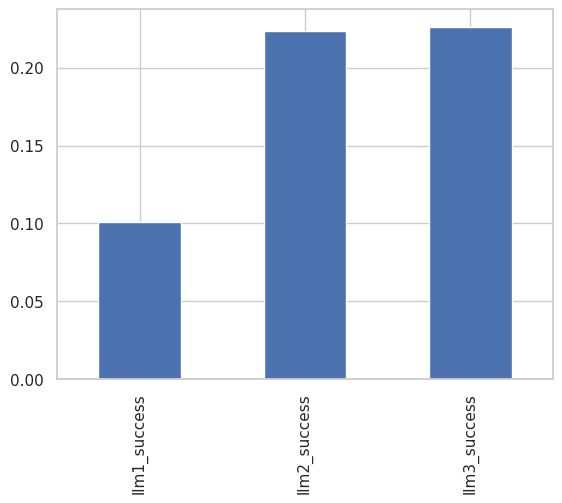

In [7]:
mean_values = ex2_2_training_data.drop(['econometrics_difficulty','readability_difficulty','negation_difficulty'],axis=1).mean()
mean_values.plot(kind='bar')

## Measurement layout

We have three meta-features/demands: `econometricsDemand`, `readabilityDemand`, and `negationDemand`. We will define mutable data nodes for each of these.

We will also consider three corresponding capabilities: `econometricsAbility`, `readabilityAbility`, and `negationAbility`. We will assume that priors for all of them are normally distributed with mean 0. For `econometricsAbility` and `readabilityAbility`, the standard deviation is set with respect to the maximum corresponding demand. The maximum demand for econometrics is 7, so we set two standard deviations for the `econometricsAbility` prior to be $7*1.2 = 8.4$, and one standard deviation is set to around 4. The maximum demand for readability is 100, so two standard deviations for `readabilityAbility` is equal to $100*1.2 = 120$, and one standard deviation is then 60.

Binary demands, like `negationDemand`, don't really have a range. So we will just assume that the prior for the corresponding ability, i.e., `negationAbility`, is normally distributed with mean 0 and a standard deviation of 1.

The margin for econometrics and readability is just the difference between the capability and demand. For binary demands, we have to use a different margin. When the binary demand is 0, this indicates that the demand is not present, in which case we expect the LLM to succeed on the task. When the demand is present, we expect the LLM to succeed on the task depending on its level of capability. More specifically, the binary margin is calculated as: $(\text{ability} - \log(\text{binary_demand} + \epsilon))$, where $\epsilon$ is a small number that ensures numeric stability, as $\log(0)$ is undefined. When the binary demand is 0, the logistic evaluates this to 1; otherwise, the output of the logistic is fully dependent on the value of $\text{ability}$. We have created a function `binary_margin` that does this for us.

Similarly to Part 1, we set the slope of the logistic based on (i) the $high\_margin$ which is just a difference between $high\_cabability$ and $min\_demand$ and (ii) the probability $p$ what we want this $high\_margin$ to be evaluated at (usually $p = 0.99$). $high\_cabability$ would be 20-30% above the max demand. So for econometrics we say that $high\_cabability = 7*1.2=8.4$, for readability $high\_cabability = 100*1.2=120$ and for negation we just assume that $high\_cabability = 2$.

We will assume that the task requires all three capabilities to succeed. That is, the three capabilities are non-compensatory. An LLM's success on the tasks will be limited by its readability ability and negation ability: even if an LLM has a high econometrics capability, that may not show up if the other two capabilities are low.

Now to implement this into PyMC. Try it for yourself using the template below. Part of the code is done for you, and a solution is located in the hidden cell following.

In [ ]:
def setupModel_2(relevantData,llm:str):


  m_ex1 = pm.Model()

  with  m_ex1:

    #demands
    econometricsDemand = pm.MutableData("econometricsDemand", relevantData["econometrics_difficulty"])
    readabilityDemand = # ENTER CODE
    negationDemand = # ENTER CODE

    #abilities
    econometricsAbility = pm.Normal("econometricsAbility", mu = 0, sigma = 4)
    readabilityAbility = # ENTER CODE
    negationAbility = # ENTER CODE

    #local performance
    econometricsP = pm.Deterministic("econometricsP", logistic_general(margin(econometricsAbility,econometricsDemand),min=1,max=7*1.2,c=0,p=0.99))
    readabilityP = # ENTER CODE
    negationP = # ENTER CODE

    #Non-compensatory interaction
    intP = econometricsP * readabilityP * negationP

    finalP = pm.Deterministic("FinalP", intP)
    observed = pm.Bernoulli("ObservedPerformance", finalP, observed =relevantData[llm+'_success'])
  return m_ex1

In [12]:
# @title Solution
def setupModel_2(relevantData,llm:str):


  m_ex1 = pm.Model()

  with  m_ex1:

    #demands
    econometricsDemand = pm.MutableData("econometricsDemand", relevantData["econometrics_difficulty"])
    readabilityDemand = pm.MutableData("readabilityDemand", relevantData["readability_difficulty"])
    negationDemand = pm.MutableData("negationDemand", relevantData["negation_difficulty"])

    #abilities
    econometricsAbility = pm.Normal("econometricsAbility", mu = 0, sigma = 4)
    readabilityAbility = pm.Normal("readabilityAbility", mu = 0, sigma = 60)
    negationAbility = pm.Normal("negationAbility", mu = 0, sigma = 1)

    #local performance
    econometricsP = pm.Deterministic("econometricsP", logistic_general(margin(econometricsAbility,econometricsDemand),min=1,max=7*1.2,c=0,p=0.99))
    readabilityP = pm.Deterministic("readabilityP", logistic_general(margin(readabilityAbility,readabilityDemand),min=0,max=100*1.2,c=0,p=0.99))
    negationP = pm.Deterministic("negationP", logistic_general(binary_margin(negationAbility,negationDemand),min=0,max=2,c=0,p=0.99))

    intP = econometricsP * readabilityP * negationP

    finalP = pm.Deterministic("FinalP", intP)
    observed = pm.Bernoulli("ObservedPerformance", finalP, observed =relevantData[llm+'_success'])
  return m_ex1

Instantiate the model

In [14]:
llm = 'llm2'
m_ex2 = setupModel_2(ex2_2_training_data,llm=llm)

Visualise the model

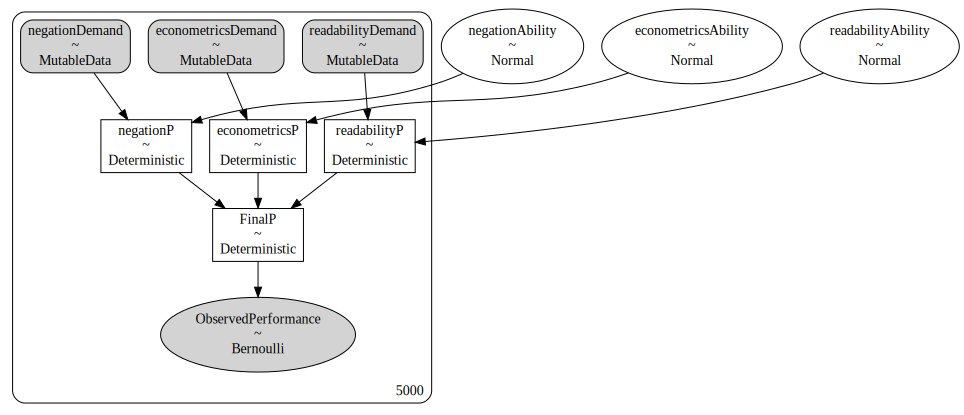

In [15]:
gv = pm.model_graph.model_to_graphviz(m_ex2)
gv

Prior predictive checks

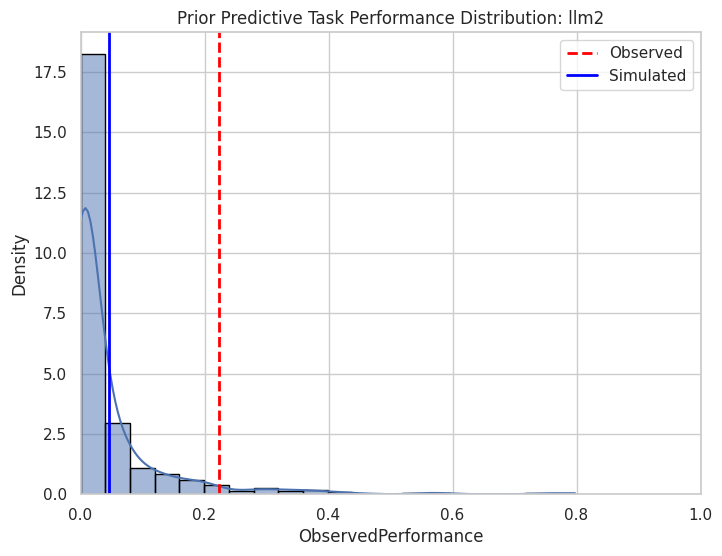

In [17]:
with m_ex2:
    prior_predictive = pm.sample_prior_predictive(samples=1_000)

process_predictive_data_and_plot_histogram(prior_predictive,predictive_type="prior",performance_var_name="ObservedPerformance",LLM=llm)

Draw samples

In [18]:
with m_ex2:
  inferenceData = pm.sample(3000, tune=2000)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


Posterior predictive checks

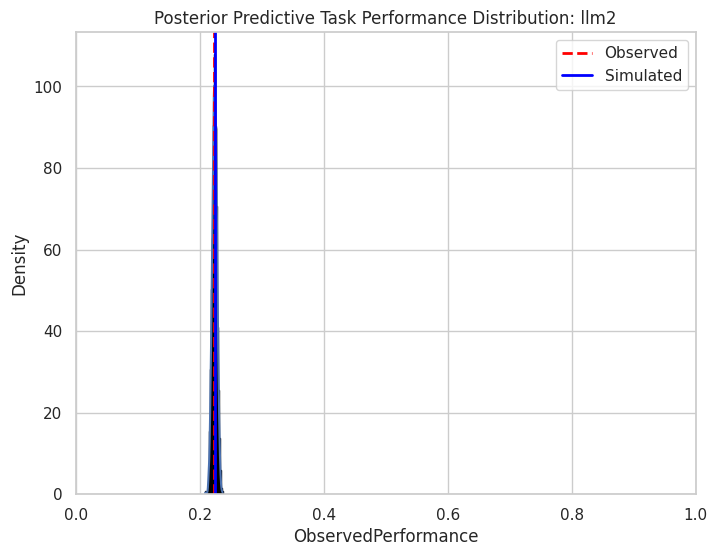

In [19]:
with m_ex2:
  posterior_predictive = pm.sample_posterior_predictive(trace=inferenceData)

process_predictive_data_and_plot_histogram(posterior_predictive,predictive_type="posterior",performance_var_name="ObservedPerformance",LLM=llm)

Visualise the posteriors

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([<Axes: title={'center': 'econometricsAbility'}>,
       <Axes: title={'center': 'readabilityAbility'}>,
       <Axes: title={'center': 'negationAbility'}>], dtype=object)

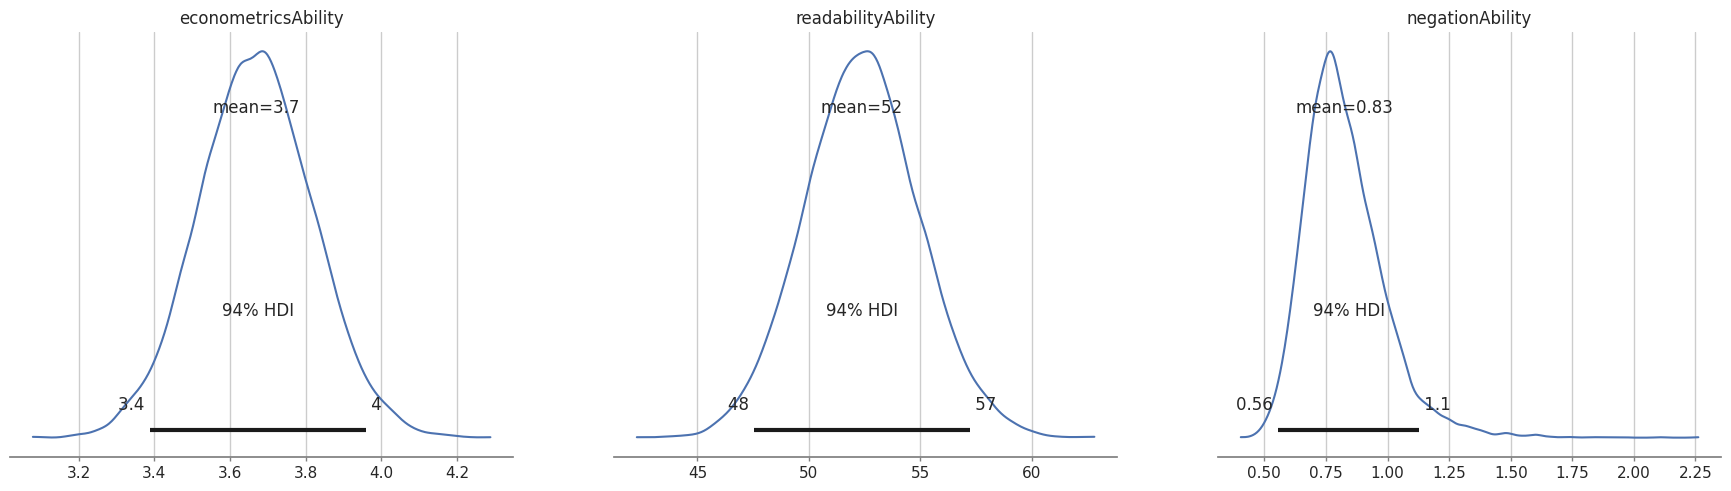

In [20]:
az.plot_posterior(inferenceData["posterior"][["econometricsAbility","readabilityAbility","negationAbility"]])

Convergence diagnostics

array([[<Axes: title={'center': 'econometricsAbility'}>,
        <Axes: title={'center': 'econometricsAbility'}>],
       [<Axes: title={'center': 'readabilityAbility'}>,
        <Axes: title={'center': 'readabilityAbility'}>],
       [<Axes: title={'center': 'negationAbility'}>,
        <Axes: title={'center': 'negationAbility'}>]], dtype=object)

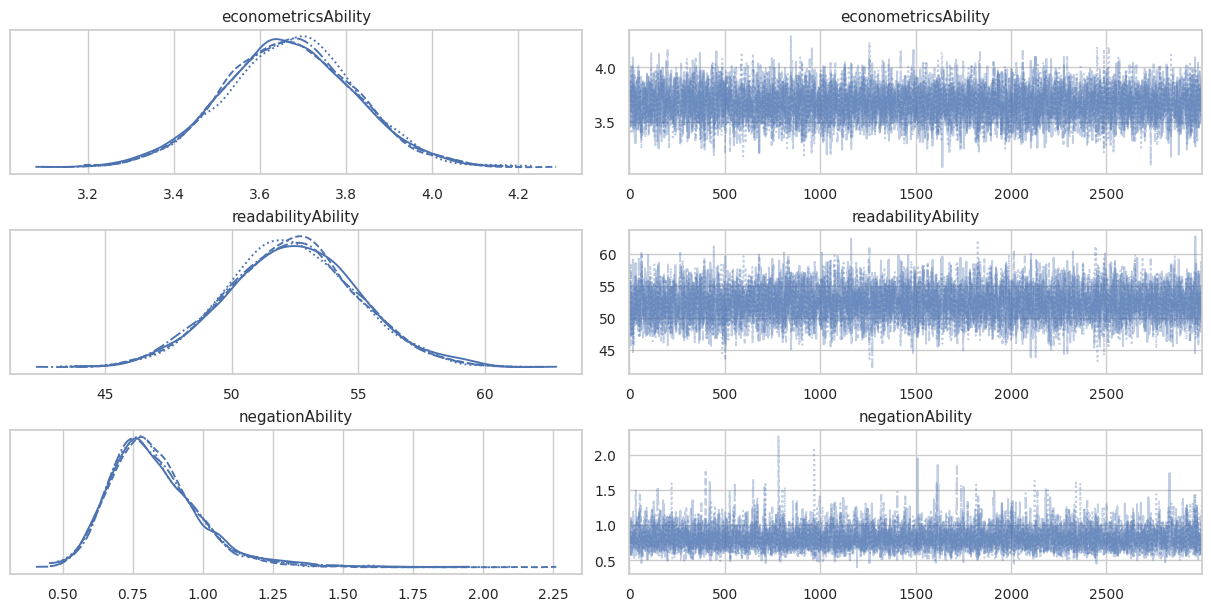

In [21]:
plt.rcParams['figure.constrained_layout.use'] = True
az.plot_trace(inferenceData["posterior"][["econometricsAbility","readabilityAbility","negationAbility"]])

<Axes: >

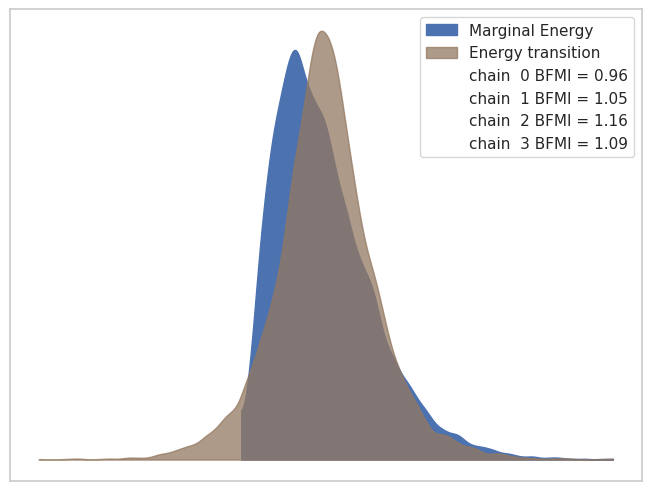

In [22]:
az.plot_energy(inferenceData)

In [23]:
az.summary(inferenceData["posterior"][["econometricsAbility","readabilityAbility","negationAbility"]])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
econometricsAbility,3.668,0.151,3.389,3.960,0.002,0.001,6035.0,6330.0,1.0
readabilityAbility,52.367,2.571,47.551,57.243,0.034,0.024,5857.0,6457.0,1.0
negationAbility,0.826,0.164,0.557,1.129,0.002,0.002,6076.0,4153.0,1.0


The convergence metrics look good. We should now build a measurement layout for each LLM.

### Measurement layouts for all three LLMs

In [ ]:
# some lists to store dictionaries posteriors, convergence metrics, and scores
llms = ['llm1','llm2','llm3']

for llm in llms:
  pass
  # instantiate the model

  #optional: plot prior predictive

  #sample from the posterior

  #optional: plot posterior predictive

  # Plot the trace plot, i.e. chains

  # plot energy plots

  # store relevant metrics: posterior mean, hdi_3, hdi_97, ess_bulk, ess_tail, r_hat; all these can be found by running az.summary

  # instantiate the model with test data

  # make predictions

  # calculate the Brier score and AUROC and store them




llm1


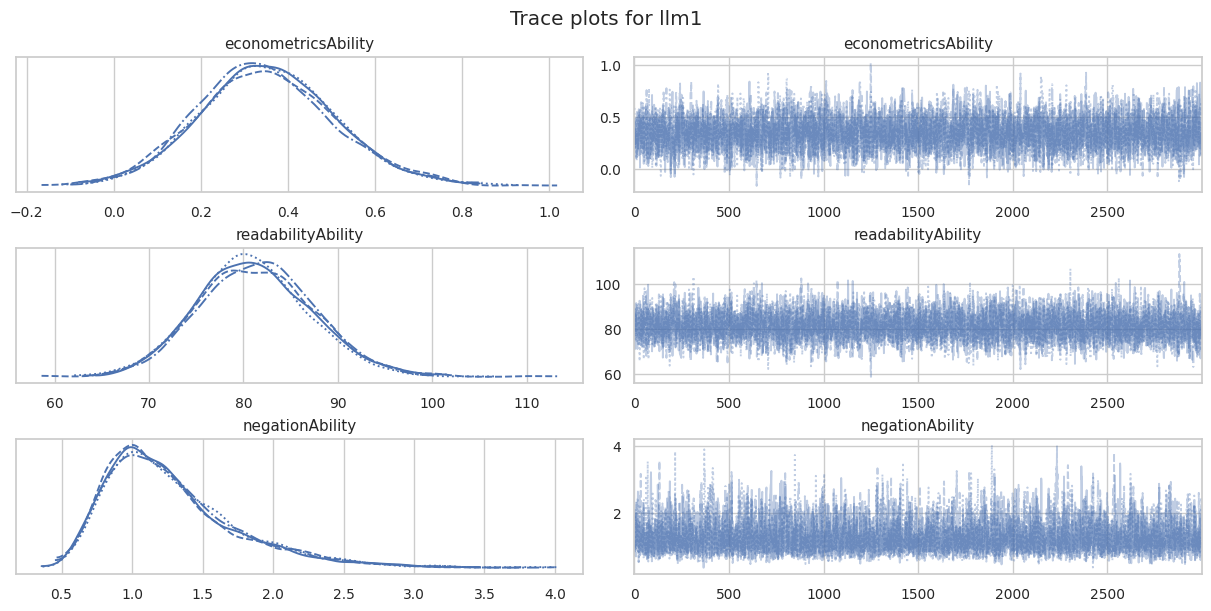

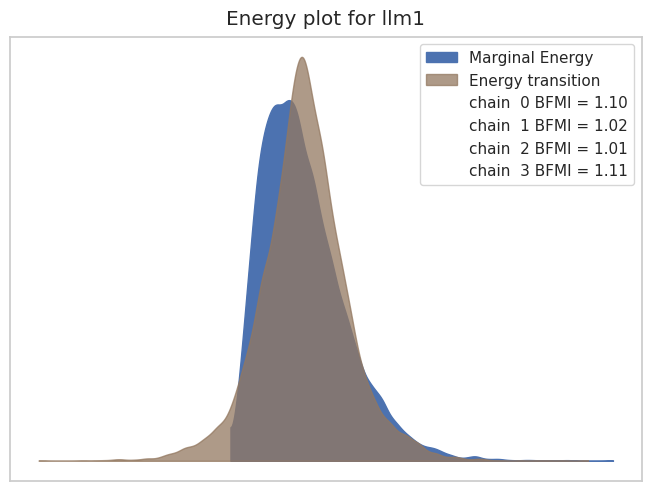

                      mean     sd  hdi_3%  hdi_97%  ess_bulk  ess_tail  r_hat
econometricsAbility  0.353  0.156   0.062    0.652  4024.446  3433.184  1.001
                      mean     sd  hdi_3%  hdi_97%  ess_bulk  ess_tail  r_hat
readabilityAbility  81.238  6.082  69.936    92.63  4232.274  4865.967  1.002
                 mean     sd  hdi_3%  hdi_97%  ess_bulk  ess_tail  r_hat
negationAbility  1.28  0.473   0.573    2.195  4308.818  4257.947  1.001


{'BrierScore': 0.07642121205555558, 'AUROC': 0.7642752825129286}

llm2


ERROR:pymc.stats.convergence:There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


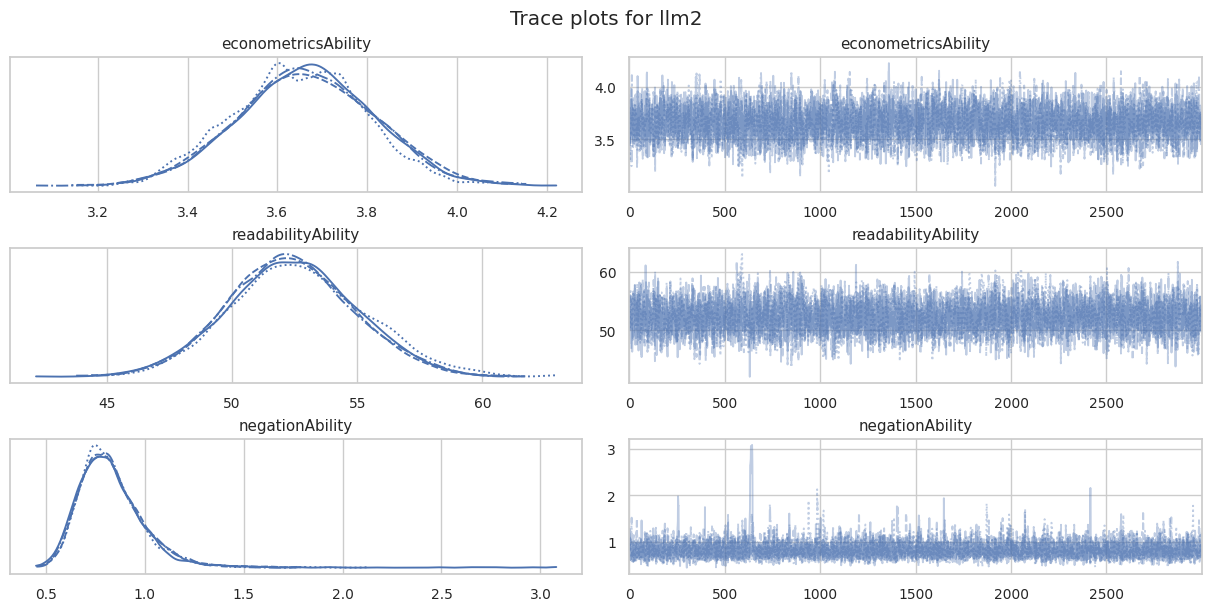

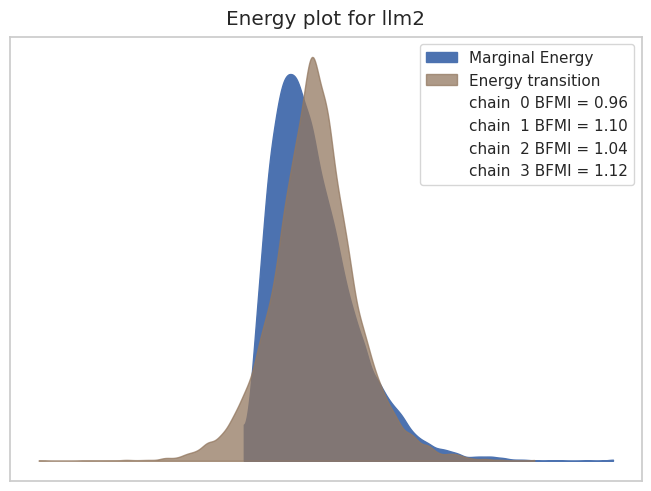

                      mean    sd  hdi_3%  hdi_97%  ess_bulk  ess_tail  r_hat
econometricsAbility  3.661  0.15   3.378    3.937  3221.242  4742.425  1.003
                      mean     sd  hdi_3%  hdi_97%  ess_bulk  ess_tail  r_hat
readabilityAbility  52.444  2.589  47.626   57.374  2861.392   2586.76  1.002
                  mean     sd  hdi_3%  hdi_97%  ess_bulk  ess_tail  r_hat
negationAbility  0.832  0.178   0.552     1.13  5200.958   4449.68    1.0


{'BrierScore': 0.14989674550694446, 'AUROC': 0.7391039212076583}

llm3


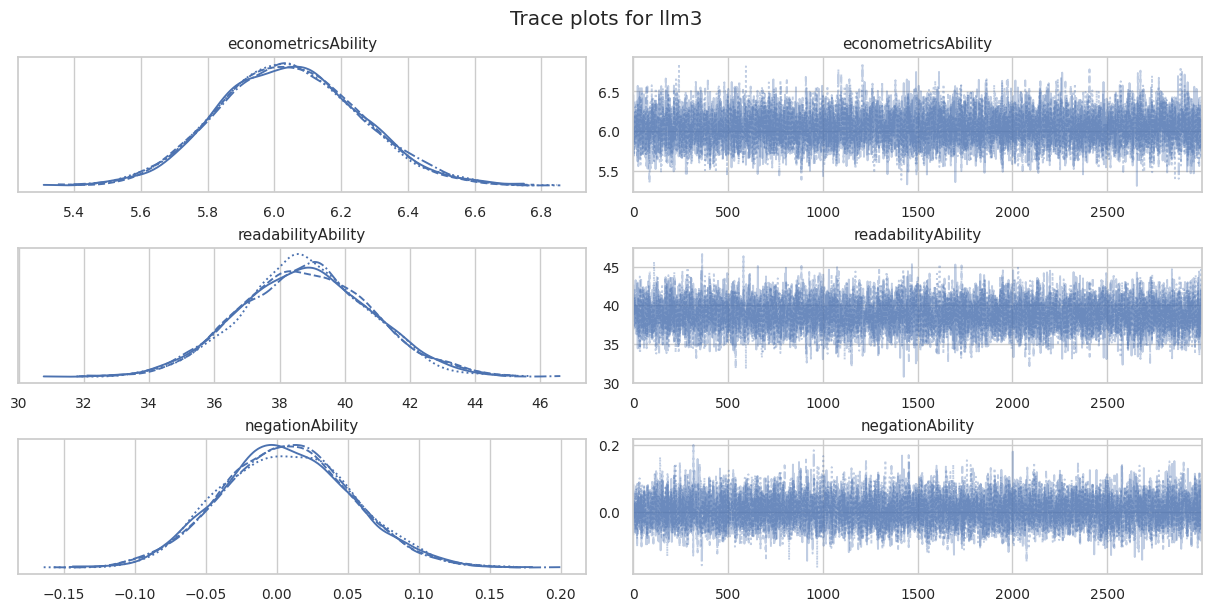

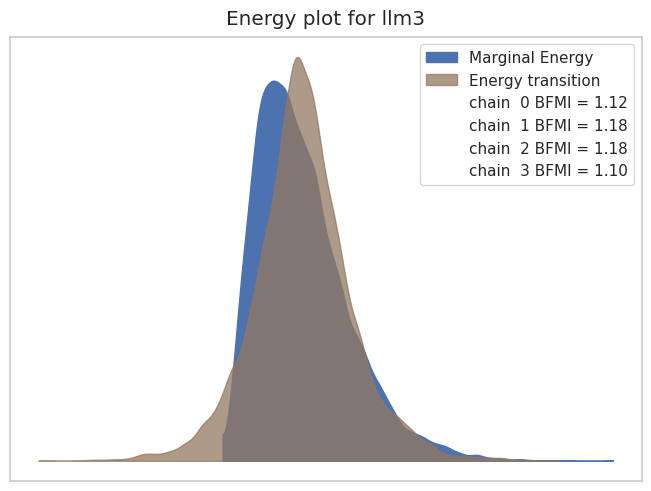

                      mean    sd  hdi_3%  hdi_97%  ess_bulk  ess_tail  r_hat
econometricsAbility  6.043  0.21   5.648    6.433  7632.066  7476.588    1.0
                      mean   sd  hdi_3%  hdi_97%  ess_bulk  ess_tail  r_hat
readabilityAbility  38.806  2.0  35.008    42.56  7067.956   7169.17    1.0
                  mean     sd  hdi_3%  hdi_97%  ess_bulk  ess_tail  r_hat
negationAbility  0.007  0.046  -0.079    0.091  7640.372  7348.728  1.001


{'BrierScore': 0.13399726970833334, 'AUROC': 0.7749913149209658}


In [27]:
# @title Example solution: Measurement layouts for each llm

scores_dict = {}
metrics_dict = {}
probabilities = {}
abilities = ["econometricsAbility","readabilityAbility","negationAbility"]
predictive_methods_df_mes_lay = pd.DataFrame()
llms = ['llm1','llm2','llm3']

for llm in llms:
    print(f'\n{llm}')

    m_ex1 = setupModel_2(ex2_2_training_data,llm=llm)

    #sample from the posterior
    with m_ex1:
      inferenceData_new = pm.sample(3000, tune=2000)

    # Plot the trace plot on the first subplot
    axes = az.plot_trace(data=inferenceData_new['posterior'][abilities])
    fig = axes.ravel()[0].figure
    fig.suptitle(f"Trace plots for {llm}")
    plt.show()

    axes = az.plot_energy(data=inferenceData_new)
    fig = axes.figure
    fig.suptitle(f"Energy plot for {llm}")
    plt.show()

    #Collect relevant metrics
    metrics_dict[llm] = {}

    for ability in abilities:

        summary = az.summary(inferenceData_new['posterior'][ability], round_to=3)

        metrics_dict[llm][ability] = {
                'mean': summary['mean'][0],
                'hdi_3%': summary['hdi_3%'][0],
                'hdi_97%': summary['hdi_97%'][0],
                'ess_bulk': summary['ess_bulk'][0],
                'ess_tail': summary['ess_tail'][0],
                'r_hat': summary['r_hat'][0],
        }
        print(summary[['mean','sd','hdi_3%','hdi_97%','ess_bulk','ess_tail','r_hat']])

    m_test = setupModel_2(ex2_2_test_data,llm=llm)

    predictions = predict(m_test, inferenceData_new, ex2_2_test_data, "ObservedPerformance")

    probabilities[llm] = predictions

    brier_score_mes_lay = brier_score_loss(ex2_2_test_data[llm+'_success'], predictions)
    roc_auc_mes_lay = roc_auc_score(ex2_2_test_data[llm+'_success'], predictions)


    scores_dict[llm] = {'BrierScore': brier_score_mes_lay, 'AUROC':roc_auc_mes_lay}
    print(scores_dict[llm])

    predictive_methods_df_mes_lay = pd.concat([predictive_methods_df_mes_lay, pd.DataFrame({"predictive_method": 'Measurement layout', "llm": llm, "BrierScore": brier_score_mes_lay, "AUROC": roc_auc_mes_lay}, index=[0])])


In [ ]:
# print out ess_bulk  ess_tail  r_hat for each llm

In [29]:
# @title Example solution: convergence metrics
data_for_df = []
for llm, abilities in metrics_dict.items():
    for ability, metrics in abilities.items():
        row = (llm, ability, metrics.get('ess_bulk'), metrics.get('ess_tail'), metrics.get('r_hat'))
        data_for_df.append(row)

# Creating the DataFrame
df = pd.DataFrame(data_for_df, columns=['LLM', 'Ability', 'ess_bulk', 'ess_tail', 'r_hat'])

# Setting LLM and Ability as the index if desired
df.set_index(['LLM', 'Ability'], inplace=True)

# Display the DataFrame
print(df)

                          ess_bulk  ess_tail  r_hat
LLM  Ability                                       
llm1 econometricsAbility  4024.446  3433.184  1.001
     readabilityAbility   4232.274  4865.967  1.002
     negationAbility      4308.818  4257.947  1.001
llm2 econometricsAbility  3221.242  4742.425  1.003
     readabilityAbility   2861.392  2586.760  1.002
     negationAbility      5200.958  4449.680  1.000
llm3 econometricsAbility  7632.066  7476.588  1.000
     readabilityAbility   7067.956  7169.170  1.000
     negationAbility      7640.372  7348.728  1.001


Visualise abilities

In [ ]:
# plot means and HDI for econometricsAbility for each llm

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
<ipython-input-43-abe3a9ca49ff>:34: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  g.fig.subplots_adjust(top=0.9)


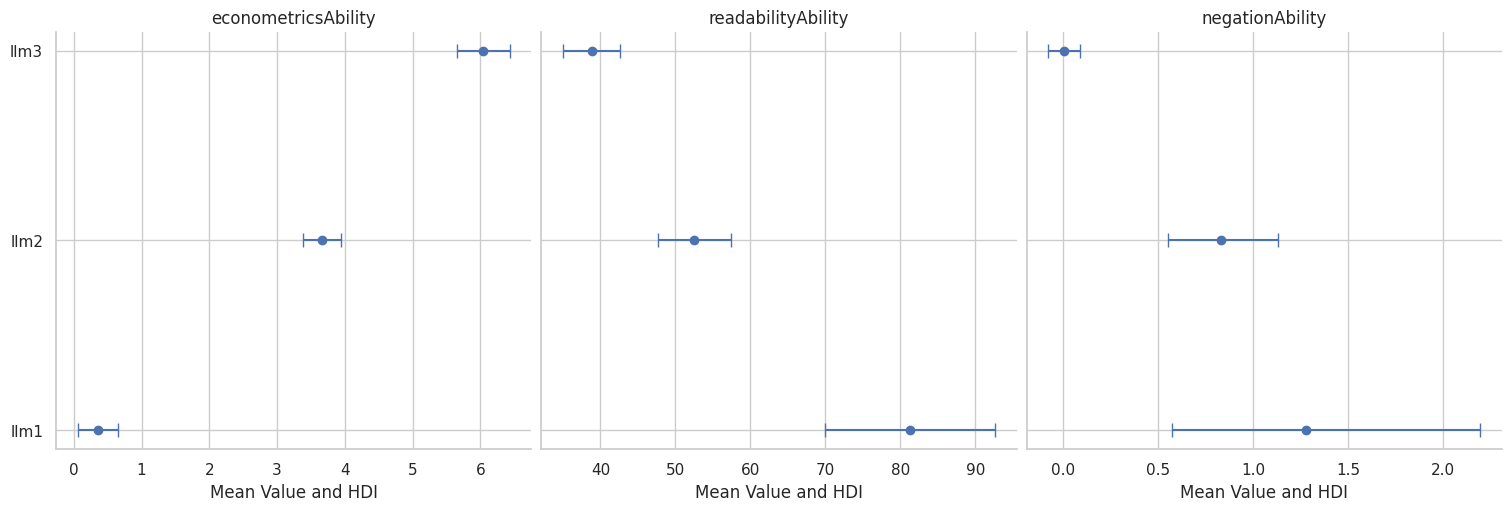

In [43]:
# @title Example solution: plot means and HDI for econometricsAbility for each llm

rows = []
for model, abilities in metrics_dict.items():
    for ability, stats in abilities.items():
        rows.append({
            'LLM': model,
            'Ability': ability,
            'Mean': stats['mean'],
            'Lower': stats['hdi_3%'],
            'Upper': stats['hdi_97%']
        })
df = pd.DataFrame(rows)

x_limits = [[-1, 8], [30, 90], [-1, 3]]

# Define a custom plotting function for use with FacetGrid
def plot_with_errorbars(data, **kwargs,):
    # Calculate the error terms as positive and negative deviations from the mean
    errors = [data['Mean'] - data['Lower'], data['Upper'] - data['Mean']]
    y_positions = range(len(data))  # Y positions for each LLM

    # Plotting the mean with error bars on the y-axis
    plt.errorbar(data['Mean'], y_positions, xerr=errors, fmt='o', capsize=5, **kwargs)
    plt.yticks(y_positions, data['LLM'])  # Set LLM names as y-ticks

# Create a FacetGrid to plot a separate subplot for each ability
g = sns.FacetGrid(df, col="Ability", sharex=False, sharey=True, height=5, aspect=1)
g.map_dataframe(plot_with_errorbars)

# Adjusting the FacetGrid
g.set_axis_labels("Mean Value and HDI", "")
g.set_titles(col_template="{col_name}")
g.fig.subplots_adjust(top=0.9)

plt.show()

We can see that LLMs' econometrics abilities are very different now. In particular, we find that even though LLM2 and LLM3 have very similar percentage success on the benchmark, they have significantly different econometrics capabilities due to their differing readability and negation abilities. Additionally, we find that LLM1 has the best reading ability of the three and a similar negation ability to LLM2 but very poor econometrics ability.

Now let's compare measurement layouts prediction power to that of XGBoosts on the test data.

In [ ]:
# train XGBoost for each llm

# make predictions on test data

# calculate Brier score and AUROC

In [46]:
# @title Example solution: compare to XGBoost

inputFeatures = ["econometrics_difficulty","readability_difficulty","negation_difficulty"]
XTrain=ex2_2_training_data[inputFeatures]
XTest = ex2_2_test_data[inputFeatures]

predictive_methods_df_xgb = predictive_methods_df_mes_lay

for llm in llms:


  outputFeature = llm+'_success'

  yTrain=ex2_2_training_data[outputFeature]
  yTest = ex2_2_test_data[outputFeature]

  model = XGBClassifier(objective='binary:logistic')

  model.fit(XTrain, yTrain)
  # Make predictions on the test data
  yPredictions = model.predict_proba(XTest)[:, 1]  # Get the probabilities for the positive class

  brier_score_xgb = brier_score_loss(yTest, yPredictions)
  roc_auc_xgb = roc_auc_score(yTest, yPredictions)

  predictive_methods_df_xgb = pd.concat([predictive_methods_df_xgb, pd.DataFrame({"predictive_method": 'XGBoost', "llm": llm, "BrierScore": brier_score_xgb, "AUROC": roc_auc_xgb}, index=[0])])

In [ ]:
#print Brier scores and AUROC for measurement layouts and XGBoost

In [48]:
# @title Example solution: print Brier scores and AUROC for measurement layouts and XGBoost

predictive_methods_df_xgb

,predictive_method,llm,BrierScore,AUROC
0,Measurement layout,llm1,0.076421,0.764275
0,Measurement layout,llm2,0.149897,0.739104
0,Measurement layout,llm3,0.133997,0.774991
0,XGBoost,llm1,0.083814,0.700417
0,XGBoost,llm2,0.162439,0.697240
0,XGBoost,llm3,0.152097,0.707210


We find that, once again, measurement layouts are comparable with XGBoost in terms of their predictive power. However, in addition to being able to predict performance on new benchmark instances, we're also able to explain their performance on the training data by appealing to the levels of inferred capabilities.